In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [8]:
import zipfile
import os
import math
import imagehash
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.callbacks import EarlyStopping

from IPython.display import FileLink

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

2025-05-25 06:01:19.602774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748152879.889798      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748152879.966059      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load Data

First of all, let's proceed to unzip the files

In [9]:
 #create a new folder inside /kaggle/working --> Full path /kaggle/working/data/train/train
## the names of the images in train folder comes with the description if it is a cat or dog, but in the test folder we have just a numeric name 

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip','r') as zip_ext:
    zip_ext.extractall('data/train')  

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip','r') as zip_ext:
    zip_ext.extractall('data/test')

In [10]:
train_dir = '/kaggle/working/data/train/train'
files = os.listdir(train_dir)

data_train=[]
for i in files:
    label = i.split('.')[0]  #dog or cat
    path = os.path.join(train_dir,i)
    data_train.append((path,label))

train_df = pd.DataFrame(data_train, columns=['filepath','label'])
train_df.head()

filepath label
0  /kaggle/working/data/train/train/dog.5827.jpg   dog
1  /kaggle/working/data/train/train/dog.5924.jpg   dog
2  /kaggle/working/data/train/train/dog.4832.jpg   dog
3  /kaggle/working/data/train/train/cat.4902.jpg   cat
4  /kaggle/working/data/train/train/dog.7744.jpg   dog

### EDA

Once we have our dataframe created and the image classified into dogs and cats, we should check first the class balancing. As we can see below, they are equally distributed so we don't need to worry about class weighting-

In [18]:
train_df['label'].value_counts()

label
dog    12500
cat    12500
Name: count, dtype: int64

In [19]:
train_df.iloc[2]['filepath']

'/kaggle/working/data/train/train/cat.1262.jpg'

It seems that our files have same size, but it would be nice to be 100% sure about this-

In [20]:
## Lets retrieve the size of the fist 5 files

for i in range(5):
    path = train_df.iloc[2]['filepath']
    with Image.open(path) as img:
        print(f'The size of the image is: {img.size}')  #(width,height)

The size of the image is: (450, 336)
The size of the image is: (450, 336)
The size of the image is: (450, 336)
The size of the image is: (450, 336)
The size of the image is: (450, 336)


In [11]:
def get_size(path):
    try:
        with Image.open(path) as img:
            return img.size
    except:
        raise ValueError('Unexpected error in path: ' +path)

In [12]:
train_df['size'] = train_df['filepath'].apply(get_size)

As we see, the dataset contains different sizes although the first 5 rows seems to be uniform in that way. One of the step that we should do before move on is normalize the sizes.

In [23]:
train_df['size'].value_counts().sort_index()

size
(42, 62)        1
(50, 38)        1
(50, 49)        2
(51, 99)        1
(54, 89)        1
               ..
(500, 497)     13
(500, 498)     12
(500, 499)     72
(1023, 768)     1
(1050, 702)     1
Name: count, Length: 8513, dtype: int64

Another thing to consider, is that as we already have the images labeled, maybe some of them are labeled with a wrong classification. Suppose that we have a picture of a cat, labeled with dog. For this, the next step is to plot some random images to have a double check.

In [24]:
train_df[train_df['label'] == 'cat'].sample(10)

filepath label        size
3770    /kaggle/working/data/train/train/cat.6390.jpg   cat  (499, 375)
22938   /kaggle/working/data/train/train/cat.2602.jpg   cat  (200, 149)
7954   /kaggle/working/data/train/train/cat.11341.jpg   cat  (499, 437)
13267  /kaggle/working/data/train/train/cat.11910.jpg   cat  (375, 499)
24279   /kaggle/working/data/train/train/cat.8701.jpg   cat  (233, 190)
7593    /kaggle/working/data/train/train/cat.5337.jpg   cat  (500, 374)
20980   /kaggle/working/data/train/train/cat.8137.jpg   cat  (500, 374)
20870   /kaggle/working/data/train/train/cat.1371.jpg   cat  (500, 374)
24915   /kaggle/working/data/train/train/cat.7656.jpg   cat  (159, 102)
9237    /kaggle/working/data/train/train/cat.3732.jpg   cat  (499, 375)

Let's define here all the functions that we are going to use for EDA!

In [13]:
def show_random_img(df_subset, n=8):
    cols = 4  # we can adjust this of course
    rows = math.ceil (n/cols)  #this is to have a flexible parameter in case that we prefer to check more images and not assuming that the row will be 1
    
    sample_df = df_subset.sample(min(n,len(df_subset)))  #retrieve n random rows, but if the df has fewer than n rows, just retrieve how many it has.
    fig, axs = plt.subplots(rows, cols, figsize=(4*cols,4*rows))
    ## in case that we got nxm it will be a 2D array, but the loop expect 1D, that is the reason why we need to flatten first
    axs = axs.flatten() if n>1 else [axs] 

    for i, (idx,row) in enumerate(sample_df.iterrows()):
        img = Image.open(row['filepath'])
        axs[i].imshow(img)
        axs[i].set_title(f"{idx} |{row['label']}")   #we add the index, because in some display results, it could be usefull to know the index in case that there is any weird picture

    plt.tight_layout()
    plt.show()        

In [14]:
## GRAYSCALE check

def is_grayscale(path):
    ## returns true is the image is not RGB
    try:
        with Image.open(path) as img:
            return img.mode != 'RGB'  #check https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
    except:
        raise ValueError('Unexpected error in path: ' +path)

In [15]:
## BLURRINESS CHECK --> For this, we will use the variance of Laplacian method, so low variance = blurry.

def is_blurry(path, threshold=100):  #https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html
    try:
        img= cv2.imread(path, cv2.IMREAD_GRAYSCALE)   #convert to grayscale for edge detection
        if img is None:
            return False
        variance = cv2.Laplacian(img,cv2.CV_64F).var()   #64-bit float
        return variance < threshold
    except:
        raise ValueError(f'Error checking blur: {path}')

In [16]:
### Duplicate images with hash library

def get_duplicate(path):
    try:
        with Image.open(path) as img:
            return str(imagehash.average_hash(img))
    except:
        return None

In [29]:
def plot_metrics(val_generator, model): 
    y_true = val_generator.classes
    y_pred_probs = model.predict(val_generator)
    y_pred = (y_pred_probs > 0.5).astype(int)  #we need to binarize the predictions. 

    report_dic = classification_report(
    y_true,
    y_pred,
    target_names=['cat','dog'],
    output_dict=True
    )
    
    report_df = pd.DataFrame(report_dic).transpose()
    report_df = report_df.round(2)  #rounds values for clarity
    report_df.style.background_gradient(cmap='Blues').format({'precision': "{:.2f}", 'recall': "{:.2f}", 'f1-score': "{:.2f}"})

    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,  #using labels,
        display_labels=['cat','dog'],
        cmap='Blues',
        normalize=None
    )

    plt.title('Normalized Confusion Matrix')
    plt.xticks(rotation=45)
    plt.show()

    return report_df.style.background_gradient(cmap='Blues').format({'precision': "{:.2f}", 'recall': "{:.2f}", 'f1-score': "{:.2f}"})


Are they cute, right? But we can assumed that they are labeled corrected! 

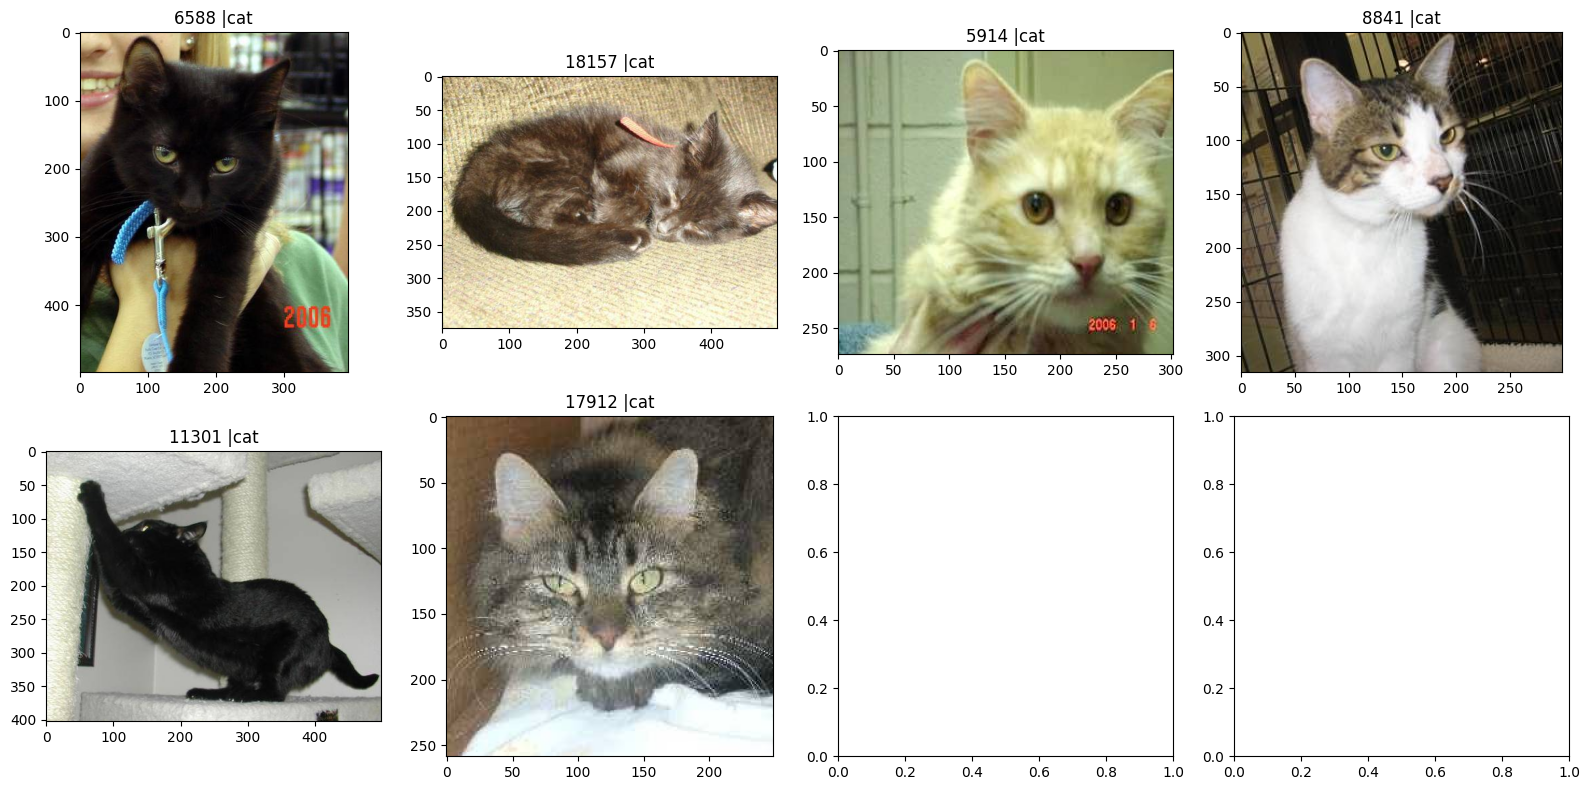

In [33]:
show_random_img(train_df[train_df['label'] =='cat'],n=6)

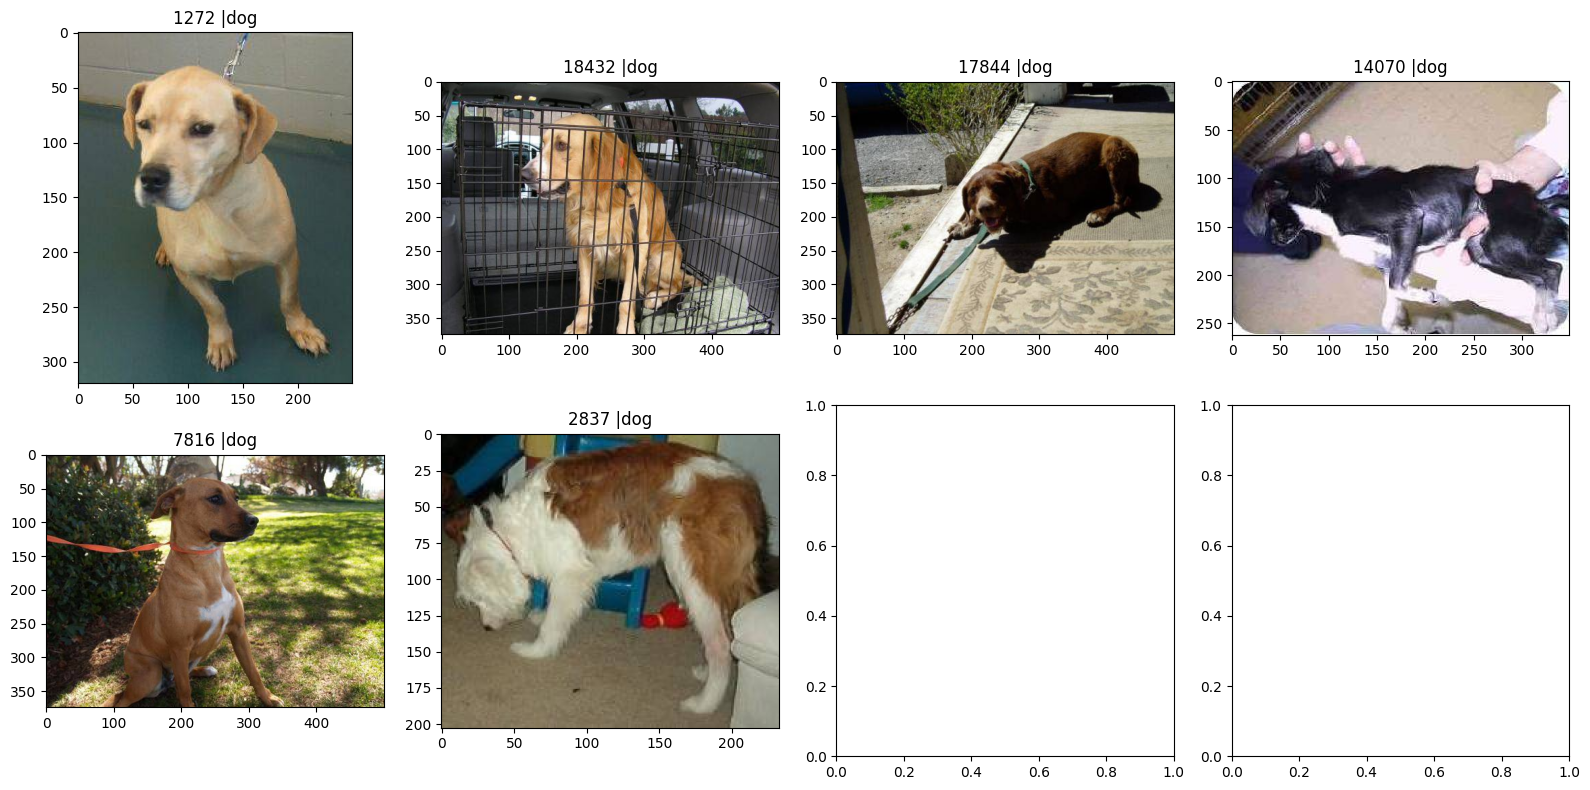

In [34]:
show_random_img(train_df[train_df['label'] =='dog'],n=6)

Before resizing the pictures, there are a few things that could be interesting to double check -  As same as we have in tabular dataset - EDA process - checking outliers, missing values, here happened something similar, and it is checking visual sanity checks - look for weird filters (sepia for instance), low quality, strange angles, blurred pictures, etc.

##### Grayscale

We affirm that our pictures are in RGB and don't contain any weird filters.

In [17]:
train_df['is_grayscale'] = train_df['filepath'].apply(is_grayscale)

train_df['is_grayscale'].value_counts()

is_grayscale
False    25000
Name: count, dtype: int64

##### Blurry

Ok, we got that around ~11% of the records are blurry enough to cross the threshold = 100; but the majority of the dataset is mostrly sharp! Next step to perfom, is to take a quickly inspection to those images!

In [18]:
train_df['is_blurry'] = train_df['filepath'].apply(is_blurry)

train_df['is_blurry'].value_counts()

is_blurry
False    22133
True      2867
Name: count, dtype: int64

Alright, we can completely indentify each picture and is easy to know if it is a cat or dog.

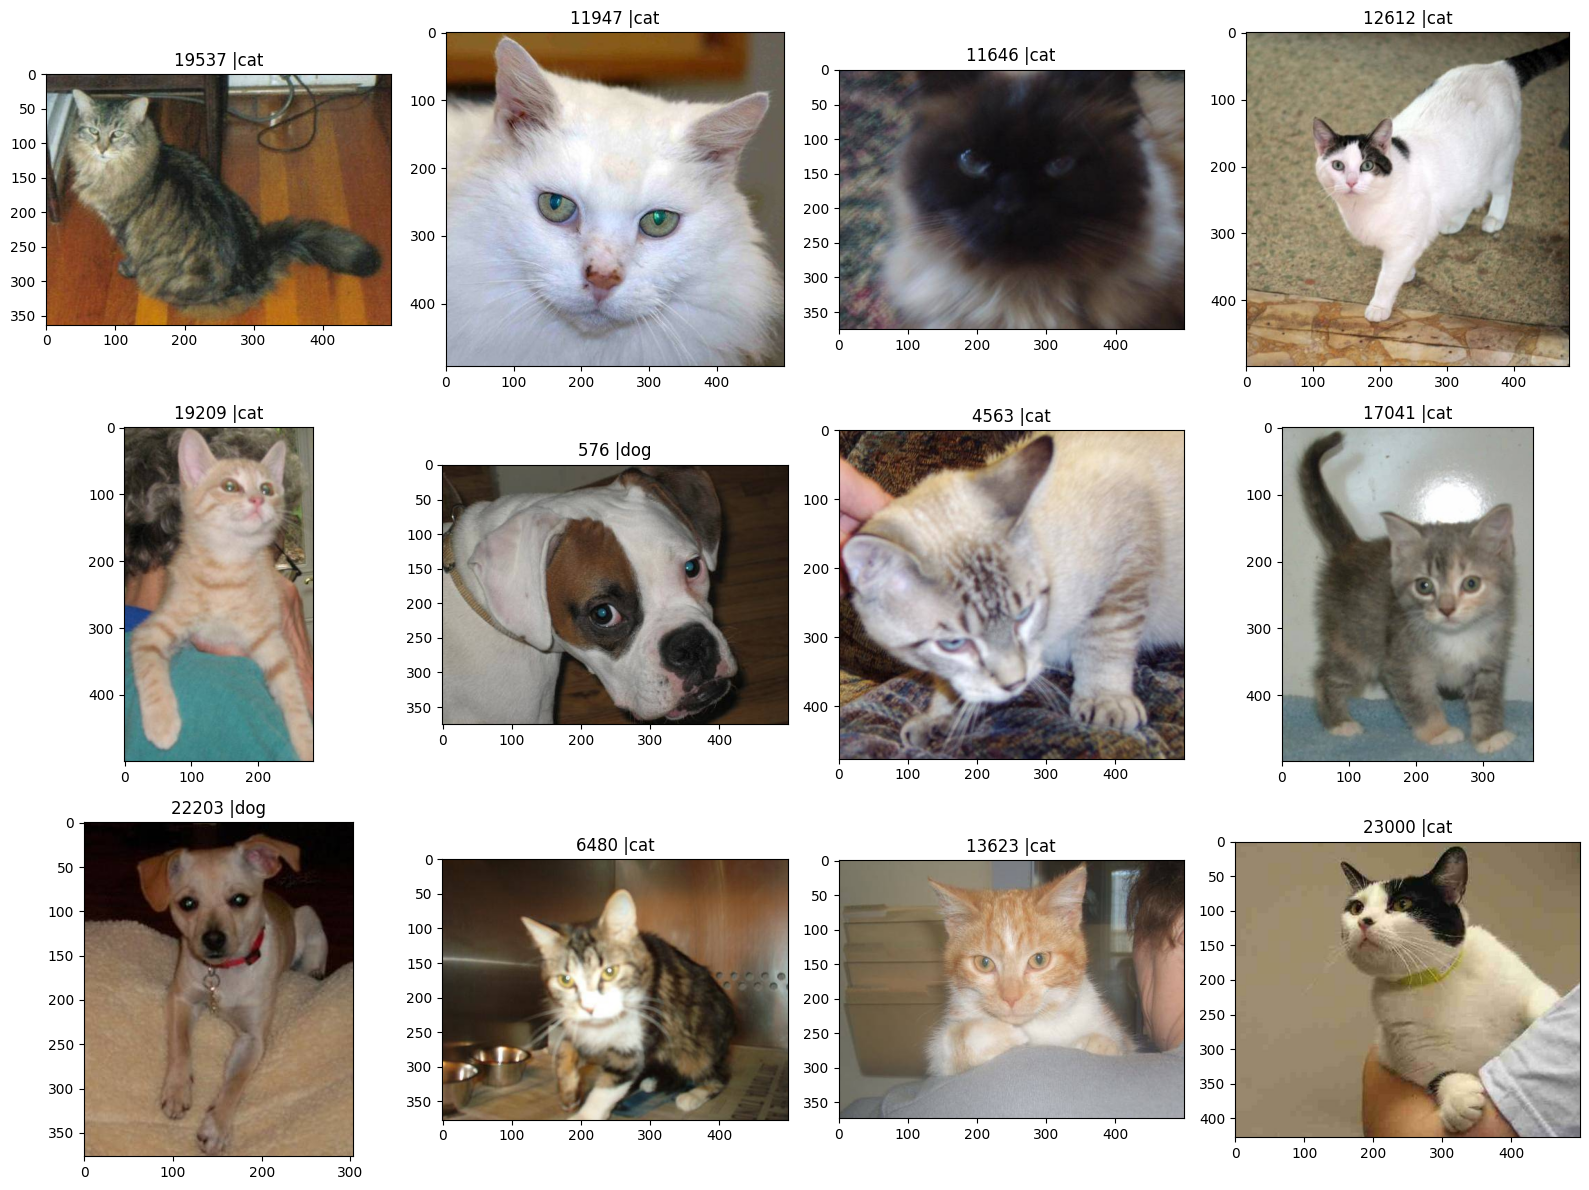

In [42]:
show_random_img(train_df[train_df['is_blurry'] == True],n=12)

##### Duplicate images

In [19]:
train_df['img_hash'] = train_df['filepath'].apply(get_duplicate)

In [20]:
duplicates = train_df[train_df.duplicated('img_hash', keep=False)]

Ok, it seems that it works! Of course, we've just showed 12 pictures, so we are not going to see each duplicate values, but we have one example where it ocurrs. Also, there is a weird picture where it said photo unvailable labeled as dog, where we clearly see that is a cat draw.
As we didn't print the index (now is included in the function) - I can't go back and tag it now.

*UPDATED* : As I have to re run the whole notebook becasue the session expired, now we have the index regarding the photo mentiones above, so we'll proceed to delete it.

In [21]:
train_df = train_df.drop([12224,14890])

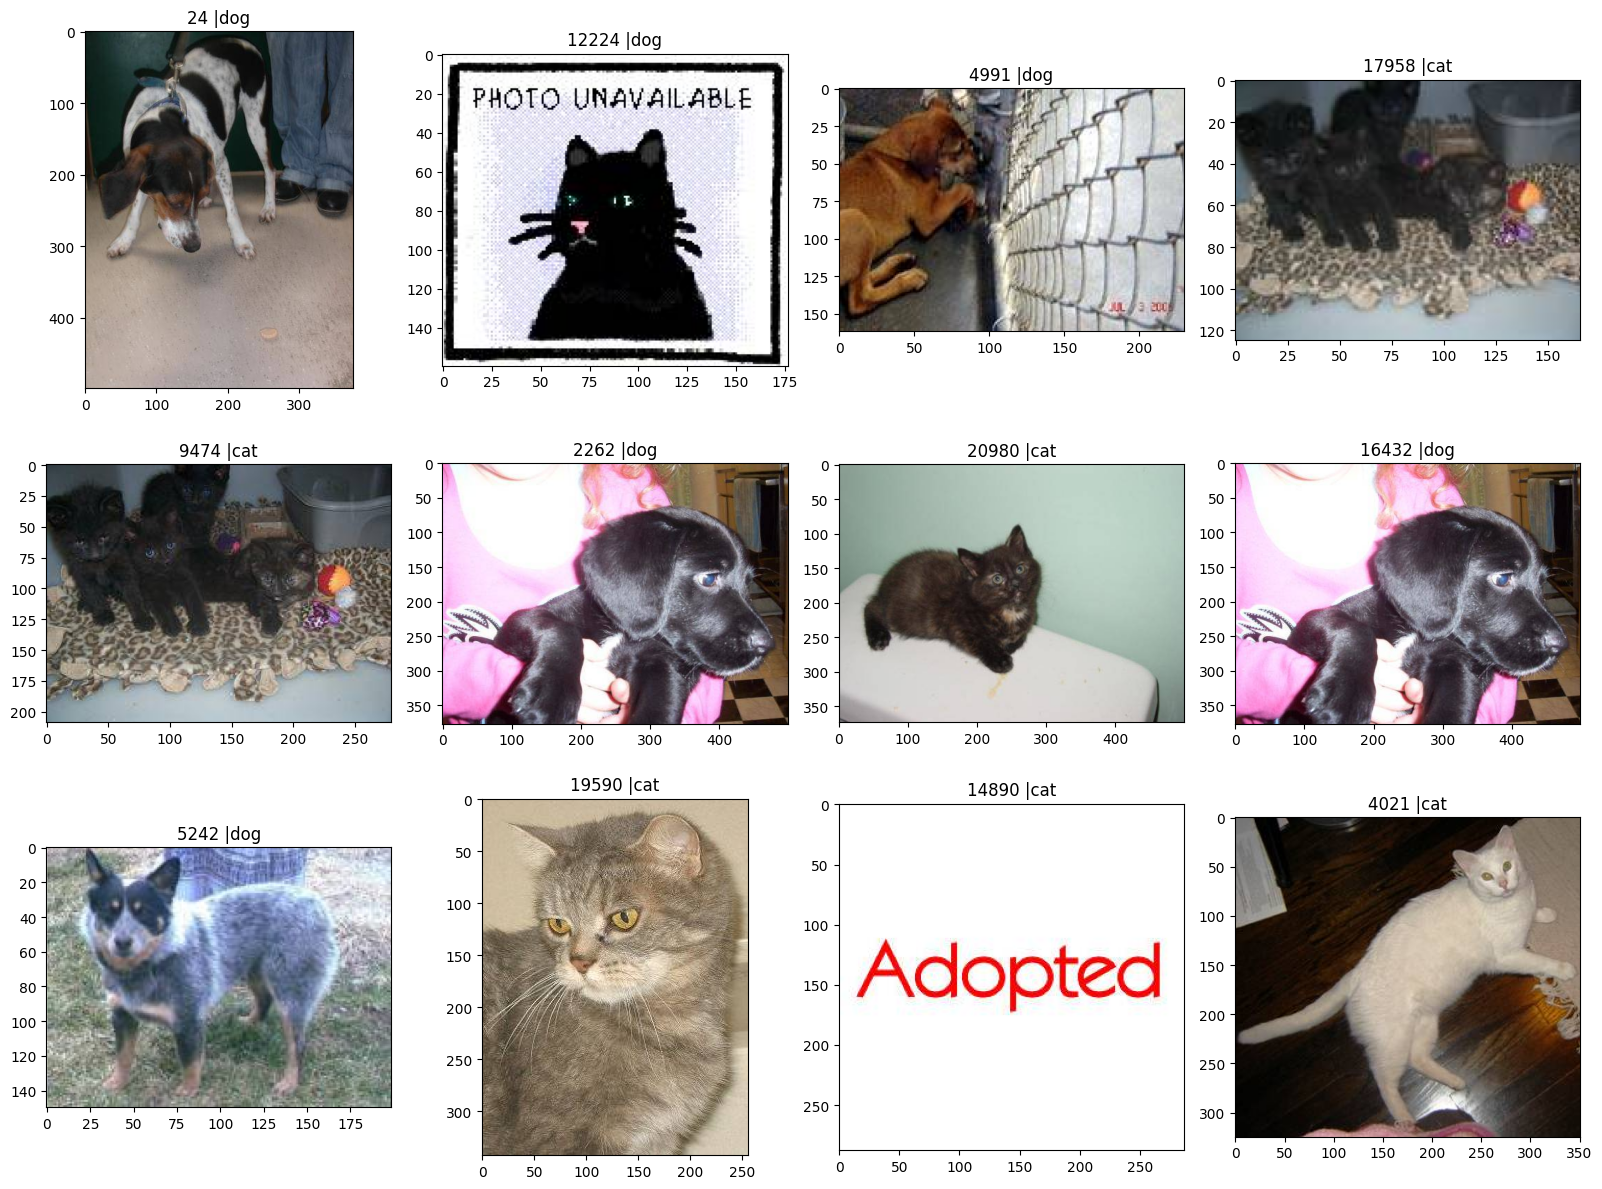

In [46]:
show_random_img(duplicates,n=12)

In [22]:
# Proceed to delete duplicate files!

train_df = train_df.drop_duplicates(subset='img_hash', keep='first')

In [23]:
## Before jumping with the model, it could be nice to save a cleaned version of our dataset; although this is a small dataset compared with other, it is a good practice to include in each work.

train_df.to_pickle('cleaned_train_df.pkl')
FileLink('cleaned_train_df.pkl')

/kaggle/working/cleaned_train_df.pkl

In [24]:
train_imagedata = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,  #randomly rotates images up to +-15º (helps model to be rotation-tolerant)
    zoom_range=0.1,   #simulates camera zoom variation
    horizontal_flip=True   #randomly flig image left <-> right || learn symmetrical patterns   
)

Ok, it is saying that 19972 are validated image. So, our train dataframe is build by 25000 rows. We said that validation_split = 20% -> it gaves us, around ~20000 images in training (~80%), this means that around 28 rows are corrupted.

In [25]:
train_generator = train_imagedata.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',   #column w full path of images
    y_col='label',
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='training',  #use the training part of the split
    shuffle=True,
    seed=42   
)

Found 19971 validated image filenames belonging to 2 classes.


In [26]:
### As we created a train_generator should do the same for val_generator to use it later in .fit

val_generator = train_imagedata.flow_from_dataframe(
    dataframe = train_df,
    x_col='filepath',
    y_col='label',
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42    
)

Found 4992 validated image filenames belonging to 2 classes.


In [27]:
### Remember that train_generator is a generator object, not a shape

model= Sequential([
    Conv2D(32,(3,3), activation = 'relu', padding='same', input_shape=train_generator.image_shape),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3), activation = 'relu',padding='same'),
    MaxPooling2D(2,2),
    Conv2D(128,(3,3), activation = 'relu',padding='same'),
    MaxPooling2D(3,3),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-25 06:03:35.246070: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall()])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[early_stop])
model.evaluate(val_generator)

## We save the model to reuse it later, so we dont have to re run everything again.
model.save('cat_vs_dogs.keras')
FileLink('cat_vs_dogs.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 487s 774ms/step - accuracy: 0.5530 - loss: 0.6820 - precision: 0.5435 - recall: 0.7452 - val_accuracy: 0.6296 - val_loss: 0.6410 - val_precision: 0.6443 - val_recall: 0.5833
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 449s 718ms/step - accuracy: 0.6271 - loss: 0.6437 - precision: 0.6445 - recall: 0.5811 - val_accuracy: 0.6633 - val_loss: 0.6130 - val_precision: 0.6329 - val_recall: 0.7819
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 503s 720ms/step - accuracy: 0.6856 - loss: 0.5932 - precision: 0.7029 - recall: 0.6464 - val_accuracy: 0.7065 - val_loss: 0.5605 - val_precision: 0.7194 - val_recall: 0.6800
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 512s 736ms/step - accuracy: 0.7027 - loss: 0.5719 - precision: 0.7166 - recall: 0.6758 - val_accuracy: 0.7272 - val_loss: 0.5422 - val_precision: 0.7031 - val_recall: 0.7891
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 472s 755ms/step - accuracy: 0.7336 - loss: 0.5370 - precision: 0.7489 - recall: 0.7042 - val_accuracy: 0

/kaggle/working/cat_vs_dogs.keras

In [ ]:
model = load_model("cats_vs_dogs_model.keras")

Let's dig in the metrics that we got from the model. 

* Loss ~0.45 --> still to improve, I guess that the model's confidence isn't very strong.
* Acc ~78.6% of total predictions were correct --> but cannot tell how it's getting wrong.
* Precision 85% of predicted class were actually correct.
* Recal 70% of the actual positive cases were correct --> Still to improve

### ResNet

In terms to see if we can improve our model based on the latest metrics -  I will use a pre trained NN

In [31]:
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,  #randomly rotates images up to +-15º (helps model to be rotation-tolerant)
    zoom_range=0.1,   #simulates camera zoom variation
    horizontal_flip=True   #randomly flig image left <-> right || learn symmetrical patterns   
)

train_generator = train_datagen_resnet.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',   #column w full path of images
    y_col='label',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    subset='training',  #use the training part of the split
    shuffle=True,
    seed=42   
)

val_generator = train_datagen_resnet.flow_from_dataframe(
    dataframe = train_df,
    x_col='filepath',
    y_col='label',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42    
)

Found 19971 validated image filenames belonging to 2 classes.
Found 4992 validated image filenames belonging to 2 classes.


In [32]:
## Load Resnet

resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)

resnet_base.trainable = False  #freeze weights so we dont retrain Imagenet layers

model_res = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall()])
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, restore_best_weights=True)
history = model_res.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[early_stop])
model_res.evaluate(val_generator)

## We save the model to reuse it later, so we dont have to re run everything again.
model_res.save('cat_vs_dogs_res.keras')
FileLink('cat_vs_dogs_res.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3240s 5s/step - accuracy: 0.9646 - loss: 0.0890 - precision_1: 0.9650 - recall_1: 0.9648 - val_accuracy: 0.9872 - val_loss: 0.0379 - val_precision_1: 0.9955 - val_recall_1: 0.9788
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3226s 5s/step - accuracy: 0.9840 - loss: 0.0409 - precision_1: 0.9827 - recall_1: 0.9851 - val_accuracy: 0.9890 - val_loss: 0.0319 - val_precision_1: 0.9904 - val_recall_1: 0.9876
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3222s 5s/step - accuracy: 0.9879 - loss: 0.0321 - precision_1: 0.9876 - recall_1: 0.9880 - val_accuracy: 0.9794 - val_loss: 0.0584 - val_precision_1: 0.9975 - val_recall_1: 0.9612
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3379s 5s/step - accuracy: 0.9889 - loss: 0.0318 - precision_1: 0.9891 - recall_1: 0.9885 - val_accuracy: 0.9884 - val_loss: 0.0323 - val_precision_1: 0.9931 - val_recall_1: 0.9836
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3367s 5s/step - accuracy: 0.9905 - loss: 0.0270 - precision_1: 0.9903 - recall_1

/kaggle/working/cat_vs_dogs_res.keras

For the next steps, it would be nice to plot a Confusion Matrix to know precisely which cases are false negative and positive, a ROC Curve to plot the true positives vs False Positive.

Okay, so the model’s performance is symmetrical. It's not biased toward one class overall, we can detect a slightly difference btw cat and doqs, where 448 cats are missed, but in overall terms is balanced.

156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 297ms/step


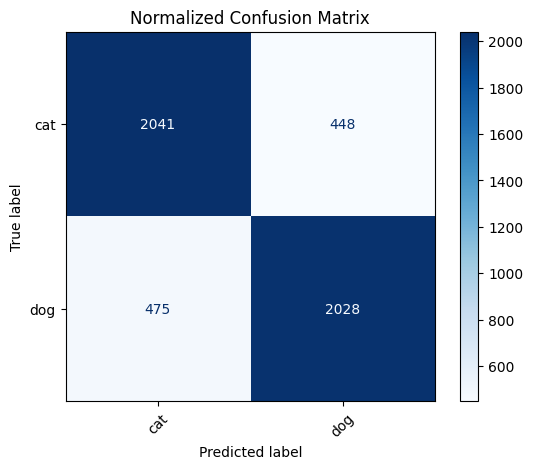

In [30]:
plot_metrics(val_generator,model)

WOW! 99% of accuracy with the pre trained neuronal network!

156/156 ━━━━━━━━━━━━━━━━━━━━ 695s 4s/step


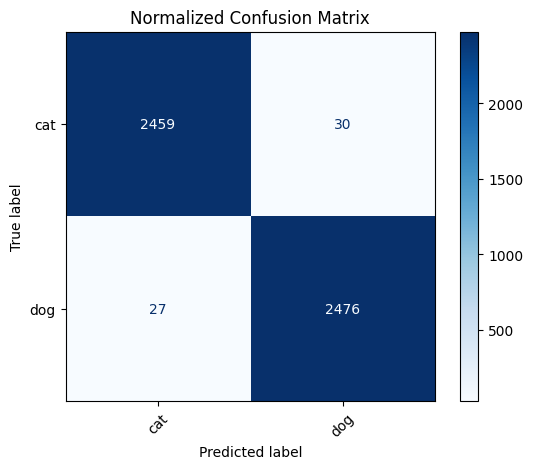

In [34]:
plot_metrics(val_generator,model_res)